In [177]:
import os
import shutil
os.chdir('/content')
if os.path.isdir('./hetvae'):
  shutil.rmtree('./hetvae/')
! git clone https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! git checkout errors
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import vae_models
importlib.reload(vae_models)
importlib.reload(models)
importlib.reload(utils)
importlib.reload(my_utils)
from glob import glob
import matplotlib.pyplot as plt
import sys
#del sys.modules['dataset']
from dataset import DataSet
%matplotlib inline

Cloning into 'hetvae'...
remote: Enumerating objects: 1853, done.
remote: Counting objects: 100% (1192/1192), done.
remote: Compressing objects: 100% (1104/1104), done.
remote: Total 1853 (delta 150), reused 1112 (delta 88), pack-reused 661
Receiving objects: 100% (1853/1853), 26.61 MiB | 5.67 MiB/s, done.
Resolving deltas: 100% (589/589), done.
Branch 'errors' set up to track remote branch 'errors' from 'origin'.
Switched to a new branch 'errors'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [178]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#-------------------------------
agn_file = '/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv'
agn_df = pd.read_csv(agn_file)
# handle formatting for new AGN
lcs = []
for lc_df in agn_df.groupby('Filter'):
    lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
    lcs.append(lc)

AGN_1H2106 = DataSet()
AGN_1H2106.dataset = lcs # skip add files part
AGN_1H2106 = AGN_1H2106.handle_dups().prune_outliers().resample_dataset(num_samples=1).normalize(normalize_y_by='individual') \
  .set_union_x().zero_fill().make_masks(frac=0.5)

print(
    AGN_1H2106.union_x.shape,
    AGN_1H2106.dataset.shape,
    AGN_1H2106.subsampled_mask.shape,
    AGN_1H2106.recon_mask.shape
  )


indexes of outliers to be pruned, if any: [600 601]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [418 583]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [ 98 205 260 261 554 555]
generating 1 new sample of each example in the dataset & appending them 
 old dataset length: 5
new dataset length: 10
created union_x attribute of length 1445
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (10, 619, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
(1445,) (10, 619, 3) (10, 619) (10, 619)


In [179]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Catalina data
#--------------------------------------------------------------------------------------------------------


lc_files = glob('/content/hetvae/data/CAT/*/*')[:50]

Catalina = DataSet().add_files(lc_files).files_to_numpy().handle_dups().prune_outliers().resample_dataset(num_samples=1).normalize(normalize_y_by='individual') \
        .set_union_x().zero_fill().make_masks(frac=0.5)

print(
    Catalina.files, '\n',
    Catalina.union_x.shape,
    Catalina.dataset.shape,
    Catalina.subsampled_mask.shape,
    Catalina.recon_mask.shape
  )


dims of /content/hetvae/data/CAT/MLS/MLS160904:221110-060547_19.78.dat:	(72, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170222:122411+113751_20.91.dat:	(87, 3)
dims of /content/hetvae/data/CAT/MLS/MLS180319:105723+035711_20.73.dat:	(142, 3)
dims of /content/hetvae/data/CAT/MLS/MLS171024:001549+031138_20.85.dat:	(152, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170105:074944+212124_20.56.dat:	(426, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170521:115341+363537_20.76.dat:	(99, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170310:130357+363042_17.37.dat:	(497, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170107:121527-012403_20.34.dat:	(402, 3)
dims of /content/hetvae/data/CAT/MLS/MLS180516:211854-035803_21.02.dat:	(43, 3)
dims of /content/hetvae/data/CAT/MLS/MLS161019:012917-043310_19.39.dat:	(203, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170323:105609+434657_19.66.dat:	(420, 3)
dims of /content/hetvae/data/CAT/MLS/MLS171023:002448+095950_20.3.dat:	(93, 3)
dims of /content/hetvae/data/CAT/M

dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_HX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_SX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [ 87  96 102]
generating 1 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 8
created union_x attribute of length 688
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (8, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
['/content/hetvae/data/EDELSON/NGC5548_W2.dat', '/content/hetvae/data/EDELSON/NGC4593_HX.dat', '/content/hetvae/data/EDELSON/NGC4593_SX.dat', '/content/hetvae/data/EDELSON/NGC5548_SX.dat'] 


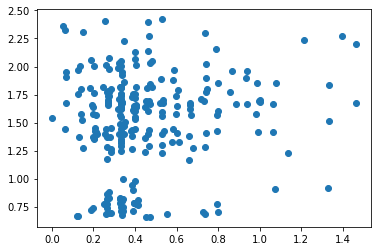

In [198]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Edelson data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/*')[:4]

# hypers: 
Edelson = DataSet().add_files(lc_files).files_to_numpy().handle_dups().prune_outliers().resample_dataset(num_samples=1).normalize(normalize_y_by='all').reorder() \
        .set_union_x().zero_fill().make_masks(frac=0.5)

print(
    Edelson.files, '\n',
    Edelson.union_x.shape,
    Edelson.dataset.shape,
    Edelson.subsampled_mask.shape,
    Edelson.recon_mask.shape
  )
plt.scatter(Edelson.dataset[0,:-10,0], Edelson.dataset[0,:-10,1])

In [181]:
# num heads?
args = Namespace(batch_size=8, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=128, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.001, mixing='concat', mse_weight=2.0, n=256, net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=16, rec_hidden=16, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512)



In [182]:
DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [183]:
LightCurves = np.concatenate((Edelson.dataset, Edelson.subsampled_mask[:,:,np.newaxis], Edelson.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 
print(LightCurves.shape)


(8, 264, 5)


In [184]:
training, valid = np.split(LightCurves, [int(np.floor(1*len(LightCurves)))])# shuffle?
train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
       

In [185]:
net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x)) # , device="cuda"
params = list(net.parameters())
optimizer = optim.Adam(params, lr=.001)

In [186]:
def train(net, optimizer,epoch, train_loader, args, device="cuda"):
      
      train_loss = 0.
      train_n = 0.
      avg_loglik, avg_kl, mse, mae = 0., 0., 0., 0.
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          #train_batch[:,:,2] = torch.ones((train_batch[:,:,3].shape))
          train_batch = train_batch.to(device)
          x = train_batch[:,:,0]
          y = train_batch[:,:,1:2]
          
          subsampled_mask = train_batch[:,:,3:4]
          recon_mask = train_batch[:,:,4:]
          error_bars = train_batch[:,:,2:3]
          # weights for loss in analogy to standard weighted least squares error 
          sample_weight = 1. / (error_bars**2)
          sample_weight[torch.isinf(sample_weight)] = 0.0
          print(sample_weight)
  
          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              y * subsampled_mask, subsampled_mask
          ), -1) 
          recon_context_y = torch.cat((            # flux values with only recon_mask values showing
                  y * recon_mask, recon_mask
              ), -1)
          


    # #   def compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              x, # context_x, times
              context_y,             # context_y
              x, # target_x, same times? 
              recon_context_y,
              num_samples=args.k_iwae, # 1? 
              beta=1,
              # optional, will be zero if not set
              sample_weight = sample_weight,

          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      
      
      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
      

In [187]:
for epoch in range(1, 1001):#args.niters + 1):
    train(net, optimizer, epoch, train_loader, args)

Streaming output truncated to the last 5000 lines.
         [ 80.3570],
         [130.5300],
         ...,
         [  0.0000],
         [  0.0000],
         [  0.0000]],

        [[  8.6693],
         [ 20.6366],
         [ 10.5289],
         ...,
         [  0.0000],
         [  0.0000],
         [  0.0000]],

        [[ 18.3534],
         [ 33.8039],
         [ 16.5639],
         ...,
         [  0.0000],
         [  0.0000],
         [  0.0000]],

        ...,

        [[  9.4626],
         [ 22.5249],
         [ 11.4923],
         ...,
         [  0.0000],
         [  0.0000],
         [  0.0000]],

        [[ 19.0270],
         [ 35.0446],
         [ 17.1718],
         ...,
         [  0.0000],
         [  0.0000],
         [  0.0000]],

        [[ 38.1612],
         [ 24.4232],
         [ 22.1526],
         ...,
         [ 30.1521],
         [  7.9749],
         [ 20.1845]]], device='cuda:0')
torch.Size([8, 16, 64]) torch.Size([8, 16, 64]) torch.Size([8, 264, 1]) pay attention!


In [ ]:
evaluate(net, train_loader)

In [174]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.001

0.01


In [46]:
def evaluate(net, train_loader, device="cuda"):
    train_loss = 0.
    train_n = 0.
    avg_loglik, mse, mae = 0,0,0
    mean_mae, mean_mse = 0,0
    with torch.no_grad():
        for i, train_batch in enumerate(train_loader):
            batch_len = train_batch.shape[0] 
            train_batch = train_batch.to(device)
            x = train_batch[:,:,0]
            y = train_batch[:,:,1:2]
            subsampled_mask = train_batch[:,:,3:4]
            recon_mask = train_batch[:,:,4:]
            error_bars = train_batch[:,:,2:3]
            seqlen = train_batch.size(1) 
            # subsampled flux values and their corresponding masks....
            context_y = torch.cat((
                y * subsampled_mask, subsampled_mask
            ), -1) 
            recon_context_y = torch.cat((            # flux values with only recon_mask values showing
                    y * recon_mask, recon_mask
                ), -1) 


      # #   def compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
            loss_info = net.compute_unsupervised_loss(
                x, # context_x, times
                context_y,             # context_y
                x, # target_x, same times? 
                recon_context_y,
                num_samples=1, #???
                beta=1,
                # optional, will be zero if not set
                error_bars = error_bars   # masked_error_bars

            )
            num_context_points = recon_mask.sum().item()
            mse += loss_info.mse * num_context_points
            mae += loss_info.mae * num_context_points
            mean_mse += loss_info.mean_mse * num_context_points
            mean_mae += loss_info.mean_mae * num_context_points
            avg_loglik += loss_info.mogloglik * num_context_points
            train_n += num_context_points
    print(
    'nll: {:.4f}, mse: {:.4f}, mae: {:.4f}, '
    'mean_mse: {:.4f}, mean_mae: {:.4f}'.format(
        - avg_loglik / train_n,
        mse / train_n,
        mae / train_n,
        mean_mse / train_n,
        mean_mae / train_n
    ))
      
    
    return float(- avg_loglik / train_n)

pred_mean: (10, 3, 264, 1) pred_std: (10, 3, 264, 1)= targets: (3, 264, 1) masks: (3, 264, 1) tps: (3, 264) inputs: (3, 264, 1)
(50, 3, 264, 1)


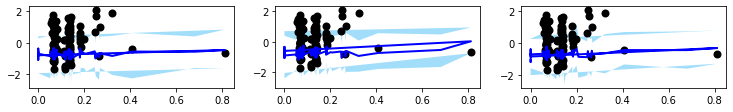

In [191]:
# visualisation for one light curve w/ increasing number of points

def viz_per_example(example, net, k_iwae=40, n_max=10, fracs=[0.2,0.2,0.5]): 
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    example = example[np.newaxis, :,:]

    np.random.seed(0)
    with torch.no_grad():
        for frac in fracs: # 
            if torch.is_tensor(example):
                example = example.cpu().numpy()

            # make new masks relative to fraction of points we got to predict w/ 
            smask, rmask = my_utils.make_masks(example, frac=frac)
            example = np.concatenate((example, smask[:,:,np.newaxis], rmask[:,:,np.newaxis]), axis=-1) # format the masks 

            # CUDA~
            example = torch.tensor(example)
            example = example.to(device)
            
            subsampled_mask = example[:,:,3:4]
            seqlen = example.size(0)
            # 
            context_y = torch.cat((example[:,:, 1:2] * subsampled_mask, subsampled_mask), -1)
            # probabilities per batch?  
            px, _ = net.get_reconstruction(example[:,:, 0], context_y, example[:,:, 0], num_samples=k_iwae)
            pred_mean.append(px.mean.cpu().numpy())
            # changing from logvar to std 
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())

            targets.append((example[:,:, 1:2]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(example[:,:, 0].cpu().numpy())

    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print(f'pred_mean: {pred_mean.shape}', f'pred_std: {pred_std.shape}=', f'targets: {targets.shape}', f'masks: {masks.shape}', f'tps: {tp.shape}', f'inputs: {inputs.shape}')
    # we're are sampling from the intermediate representation w/ k_iwae
    # then we sample from the means/stds from the intermediate representation w/ k_iwae
    
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    print(preds.shape)
    median = preds.mean(0)
    quantile2 = np.quantile(preds, 0.859, axis=0)
    quantile1 = np.quantile(preds, 0.141, axis=0)
    
    w = 2.0
    plt.figure(figsize=(12.5, 1.5))
    for j in range(3):
        plt.subplot(1, 3, j + 1)
        plt.fill_between(tp[j], quantile1[j, :, 0], quantile2[j, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
        plt.plot(tp[j], median[j, :, 0], c='b', lw=w, label='Reconstructions')
        #plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
        plt.scatter(tp[j], inputs[j, :, 0], c='k', lw=w, label='Observed Data')
    plt.show()

viz_per_example(Edelson.dataset[2], net, k_iwae=10, n_max=10, fracs=[.5,0.8,.9])

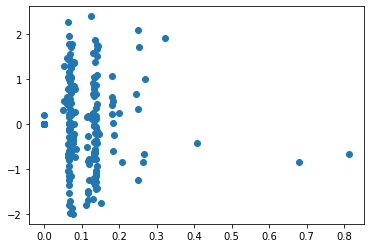

In [193]:
plt.scatter(Edelson.dataset[2][:,0], Edelson.dataset[2][:,1])